In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from PIL import Image
from pycocotools.coco import COCO
import torch

from COCODataset import MaskedCOCODataset
from COCOWrapper import COCOWrapper
from ImageLoader import ImageLoader


In [3]:
# Create an altered version of the dataset

root = '/home/gregory/Datasets/COCO/'
mode = 'val'
year = '2017'

base = '{}{}{}/'.format(root, mode, year)

coco = COCOWrapper(root = root, mode = mode, year = year)

loader = ImageLoader(root = base, coco = coco.coco)



loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [4]:
# coco is a COCOWrapper, loader is an ImageLoader
def create(model_class, labeler_classes, coco, loader, save_dir = './DataAugmentation/'):
    
    img_location = '{}{}{}/'.format(root, mode, year)
    save_location = '{}/{}-{}/'.format(save_dir, model_class, labeler_classes).replace("'", '')
        
    os.system('rm -rf {}'.format(save_location))
    os.system('mkdir {}'.format(save_location))
     
    # Start by getting all of the images that contain the target classes according to the labeler
    relevant_classes = [model_class]
    for c in labeler_classes:
        relevant_classes.append(c)
    
    img_objs = coco.get_images_with_cats(relevant_classes)
    n = len(img_objs)
    
    labels = []
    labels_masked = coco.get_cat_ids(labeler_classes)
    for i in range(n):
        img_obj = img_objs[i]
        file = '{}{}'.format(save_location, img_obj['file_name'])
     
        # Load and save the masked version of the image
        img = loader.load_img(img_obj, transform_apply = False, mask_apply = True, mask_classes = labeler_classes)
        img.save(file)
        
        # Get the label of the image
        annotations = coco.get_annotations(img_obj)
        label = np.zeros((91), dtype = np.float32)
        for ann in annotations:
            label[ann['category_id']] = 1.0
                
        # Remove the masked objects from the label
        label[labels_masked] = 0.0

        labels.append((file, label))
    
    with open('{}labels.p'.format(save_location), 'wb') as f:
        pickle.dump(labels, f)
    


In [5]:
create('frisbee', ['person'], coco, loader)

In [6]:

dataset = MaskedCOCODataset('./DataAugmentation/frisbee-[person]/labels.p')
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True, num_workers = 4)


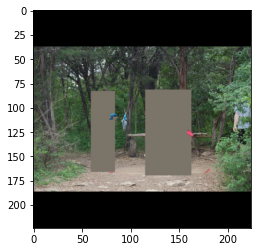

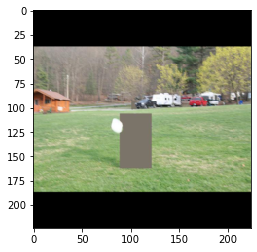

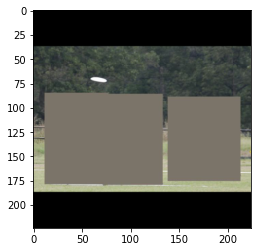

In [7]:
it = iter(dataset)

for i in range(3):
    x,y = next(it)
    plt.imshow(loader.t2np(x))
    plt.show()